# How close are Codon and Amino Acid embeddings of the same sequence?

## Start with visualization
Let's look at t-SNE of (1) the codon embeddings, (2) the amino acid embeddings, and (3) the combined embeddings.

### First generate embeddings for codon and amino acid sequences

In [31]:
import re
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pathlib import Path
from typing import Dict, List, Any
from dataclasses import dataclass
from Bio.SeqUtils import gc_fraction
from torch.utils.data import DataLoader, Dataset
from transformers import (
    PreTrainedTokenizerFast,
    BatchEncoding,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    EsmForMaskedLM,
    EsmTokenizer,
)
#from train import GenSLMColatorForLanguageModeling, FastaDataset

# Stop codons map to empty strings ""
translation_table = {
    "TTT": "F",
    "TTC": "F",
    "TTA": "L",
    "TTG": "L",
    "TCT": "S",
    "TCC": "S",
    "TCA": "S",
    "TCG": "S",
    "TAT": "Y",
    "TAC": "Y",
    "TGT": "C",
    "TGC": "C",
    "TGG": "W",
    "CTT": "L",
    "CTC": "L",
    "CTA": "L",
    "CTG": "L",
    "CCT": "P",
    "CCC": "P",
    "CCA": "P",
    "CCG": "P",
    "CAT": "H",
    "CAC": "H",
    "CAA": "Q",
    "CAG": "Q",
    "CGT": "R",
    "CGC": "R",
    "CGA": "R",
    "CGG": "R",
    "ATT": "I",
    "ATC": "I",
    "ATA": "I",
    "ATG": "M",
    "ACT": "T",
    "ACC": "T",
    "ACA": "T",
    "ACG": "T",
    "AAT": "N",
    "AAC": "N",
    "AAA": "K",
    "AAG": "K",
    "AGT": "S",
    "AGC": "S",
    "AGA": "R",
    "AGG": "R",
    "GTT": "V",
    "GTC": "V",
    "GTA": "V",
    "GTG": "V",
    "GCT": "A",
    "GCC": "A",
    "GCA": "A",
    "GCG": "A",
    "GAT": "D",
    "GAC": "D",
    "GAA": "E",
    "GAG": "E",
    "GGT": "G",
    "GGC": "G",
    "GGA": "G",
    "GGG": "G",
    "TAG": "",
    "TAA": "",
    "TGA": "",
}

def group_codons(seq: str) -> str:
    return " ".join(seq[i : i + 3] for i in range(0, len(seq), 3)).upper()


def codon_seq_to_amino_acid(codon_seq: str) -> str:
    return "".join(translation_table[codon] for codon in codon_seq.split())


class FastaDataset(Dataset):
    def __init__(
        self,
        file_path: str,
        return_codon: bool = True,
        return_aminoacid: bool = False,
    ) -> None:
        self.return_codon = return_codon
        self.return_aminoacid = return_aminoacid

        # Read the fasta file
        dna_sequenes = self.read_fasta_only_seq(file_path)
        # Preprocess the sequences into codons
        self.sequences = [
            group_codons(seq) for seq in dna_sequenes if len(seq) % 3 == 0
        ]

    def read_fasta_only_seq(self, fasta_file: str) -> List[str]:
        """Reads fasta file sequences without description tag."""
        text = Path(fasta_file).read_text()
        pattern = re.compile("^>", re.MULTILINE)
        non_parsed_seqs = re.split(pattern, text)[1:]
        lines = [
            line.replace("\n", "")
            for seq in non_parsed_seqs
            for line in seq.split("\n", 1)
        ]
        return lines[1::2]

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, idx: int) -> Dict[str, str]:
        # Get the idx'th codon sequence
        codon_sequence = self.sequences[idx]

        # The output data dictionary to be returned
        data = {}

        # Return the codon sequence
        if self.return_codon:
            data["codon"] = codon_sequence

        # Return the amino acid sequence
        if self.return_aminoacid:
            data["aminoacid"] = codon_seq_to_amino_acid(codon_sequence)

        return data

class GenSLMColatorForLanguageModeling(DataCollatorForLanguageModeling):
    """Augment the underlying DataCollatorForLanguageModeling to handle
    multiple batch encoding inputs."""

    def __init__(
        self,
        return_codon: bool = True,
        return_aminoacid: bool = False,
        train_mode: bool = False,
        **kwargs,
    ):
        self.return_codon = return_codon
        self.return_aminoacid = return_aminoacid
        self.train_mode = train_mode
        super().__init__(**kwargs)

    def tokenize(self, sequences: List[str]) -> BatchEncoding:
        return self.tokenizer(
            sequences,
            return_tensors="pt",
            truncation=True,
            padding=True,
            return_special_tokens_mask=self.train_mode,
        )

    def torch_call_helper(self, batch: BatchEncoding) -> BatchEncoding:
        # We only need to mask tokens if we are training
        if not self.train_mode:
            return batch
        # If special token mask has been preprocessed, pop it from the dict.
        special_tokens_mask = batch.pop("special_tokens_mask", None)
        if self.mlm:
            batch["input_ids"], batch["labels"] = self.torch_mask_tokens(
                batch["input_ids"], special_tokens_mask=special_tokens_mask
            )
        else:
            labels = batch["input_ids"].clone()
            if self.tokenizer.pad_token_id is not None:
                labels[labels == self.tokenizer.pad_token_id] = -100
            batch["labels"] = labels
        return batch

    def torch_call(self, examples: List[Dict[str, BatchEncoding]]) -> Dict[str, Any]:
        if self.return_codon and self.return_aminoacid:
            # The first half of the batch is the codon sequences
            # and the second half is the amino acid sequences
            tokenized_seqs = self.tokenize(
                [e["codon"] for e in examples] + [e["aminoacid"] for e in examples]
            )
            return self.torch_call_helper(tokenized_seqs)
        elif self.return_codon:
            tokenized_seqs = self.tokenize([e["codon"] for e in examples])
            return self.torch_call_helper(tokenized_seqs)
        elif self.return_aminoacid:
            tokenized_seqs = self.tokenize([e["aminoacid"] for e in examples])
            return self.torch_call_helper(tokenized_seqs)
        assert False

# TODO: Implement JIT compile model: https://huggingface.co/docs/transformers/torchscript
def generate_embeddings(model, dataloader):
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = batch.to(model.device)
            outputs = model(**batch, output_hidden_states=True)
            last_hidden_states = outputs.hidden_states[-1]
            seq_lengths = batch.attention_mask.sum(axis=1)
            for seq_len, elem in zip(seq_lengths, last_hidden_states):
                # Compute averaged embedding
                embedding = elem[1 : seq_len - 1, :].mean(dim=0).cpu().numpy()
                embeddings.append(embedding)

    return np.array(embeddings)


def scatter_plot(plot_df, label_paint_name: str, label_note: str = ""):
    with plt.style.context("seaborn-poster"):
        fig = plt.figure(figsize=(10, 10))  # noqa
        ax = sns.scatterplot(
            data=plot_df,
            x="x",
            y="y",
            palette="viridis",
            hue=label_paint_name,
            legend=True,
            edgecolor="white",
            linewidth=0,
            s=15,
        )
        plt.xlabel(r"$z_1$", fontsize=22)
        plt.ylabel(r"$z_2$", fontsize=22)
        plt.suptitle(f"{label_paint_name} {label_note}")
        plt.rc("legend", fontsize=22)
        ax.tick_params(axis="both", which="major", labelsize=22)
        ax.tick_params(axis="both", which="minor", labelsize=22)
        sns.move_legend(
            ax,
            "lower center",
            bbox_to_anchor=(0.5, -0.25),
            ncol=4,
            title=None,
            frameon=False,
        )

In [19]:
@dataclass
class GenSLMInferenceConfig:
    # Could also be an ESM checkpoint, e.g. "esm1_t34_670M_UR50S"
    model_path: str = "/lambda_stor/homes/abrace/src/genslm-esm/mdh_application/mdh_natural_sequences_run_1/checkpoint-5500"
    tokenizer_path: str = "/lambda_stor/homes/abrace/src/genslm-esm/tokenizer_esm_genslm"
    data_path: str = "/lambda_stor/homes/khippe/genslm_foundation/genome_data/mdh_sc23/fasta/mdh_natural_sequences.ffn"
    per_device_eval_batch_size: int = 128

config = GenSLMInferenceConfig()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = EsmTokenizer.from_pretrained(config.tokenizer_path)
model = EsmForMaskedLM.from_pretrained(config.model_path)
model.to(device).eval()

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(97, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_a

In [20]:
# Generate codon embeddings
return_codon, return_aminoacid = True, False

dataset = FastaDataset(   
    file_path=config.data_path,
    return_codon=return_codon,
    return_aminoacid=return_aminoacid,
)

data_collator = GenSLMColatorForLanguageModeling(
    return_codon=return_codon,
    return_aminoacid=return_aminoacid,
    tokenizer=tokenizer,
)

dataloader = DataLoader(
    dataset,
    batch_size=512,
    collate_fn=data_collator,
    num_workers=4,
    pin_memory=True
)

codon_embeddings = generate_embeddings(model, dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:59<00:00,  1.22it/s]


In [21]:
codon_embeddings.shape

(36624, 320)

In [22]:
# Generate codon embeddings
return_codon, return_aminoacid = False, True

dataset = FastaDataset(   
    file_path=config.data_path,
    return_codon=return_codon,
    return_aminoacid=return_aminoacid,
)

data_collator = GenSLMColatorForLanguageModeling(
    return_codon=return_codon,
    return_aminoacid=return_aminoacid,
    tokenizer=tokenizer,
)

dataloader = DataLoader(
    dataset,
    batch_size=512,
    collate_fn=data_collator,
    num_workers=4,
    pin_memory=True
)

aminoacid_embeddings = generate_embeddings(model, dataloader)
aminoacid_embeddings.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:58<00:00,  1.24it/s]


(36624, 320)

In [41]:
# Save embeddings
np.save("averaged_codon_embeddings.npy", codon_embeddings)
np.save("averaged_aminoacid_embeddings.npy", aminoacid_embeddings)

In [27]:
gc_content = [gc_fraction(seq) for seq in dataset.sequences]

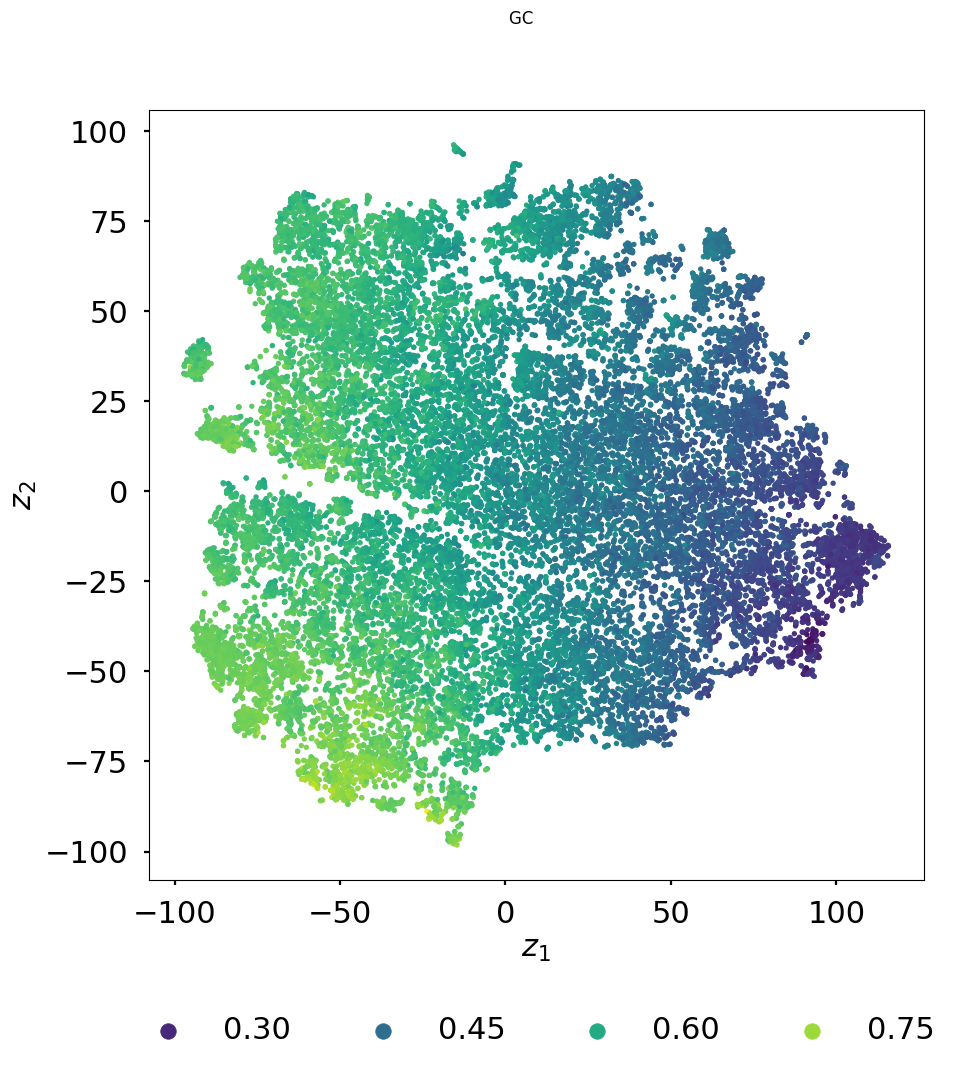

In [34]:
# Codon embeddings
tsne_embeddings = TSNE(n_components=2).fit_transform(codon_embeddings)
plot_df = pd.DataFrame({"x": tsne_embeddings[:, 0], "y": tsne_embeddings[:, 1], "GC": gc_content})
scatter_plot(plot_df, "GC")
plt.show()

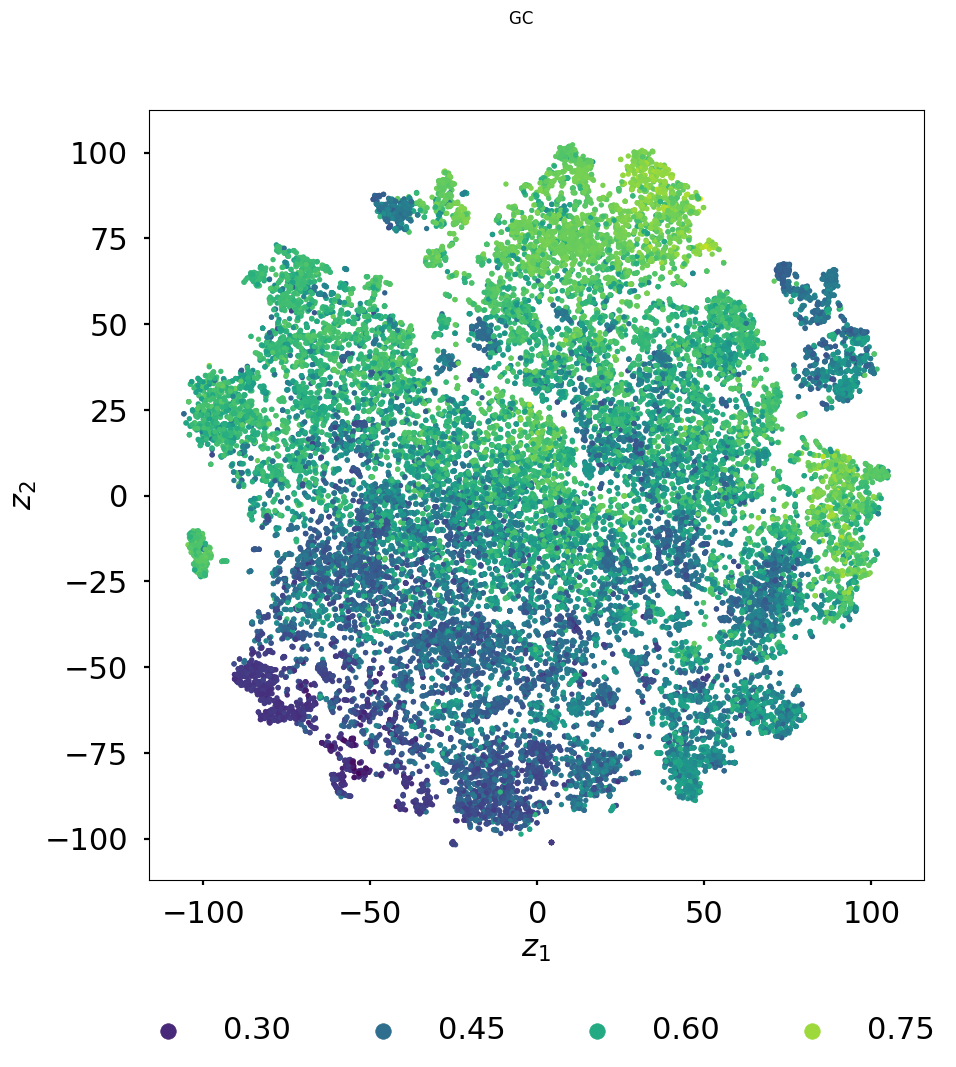

In [32]:
# Amino Acid embeddings
tsne_embeddings = TSNE(n_components=2).fit_transform(aminoacid_embeddings)
plot_df = pd.DataFrame({"x": tsne_embeddings[:, 0], "y": tsne_embeddings[:, 1], "GC": gc_content})
scatter_plot(plot_df, "GC")

In [36]:
combined_embeddings = np.concatenate((codon_embeddings, aminoacid_embeddings))
codon_or_aa = (["Codon"] * len(codon_embeddings)) + (["Amino Acid"] * len(aminoacid_embeddings))
combined_embeddings.shape

(73248, 320)

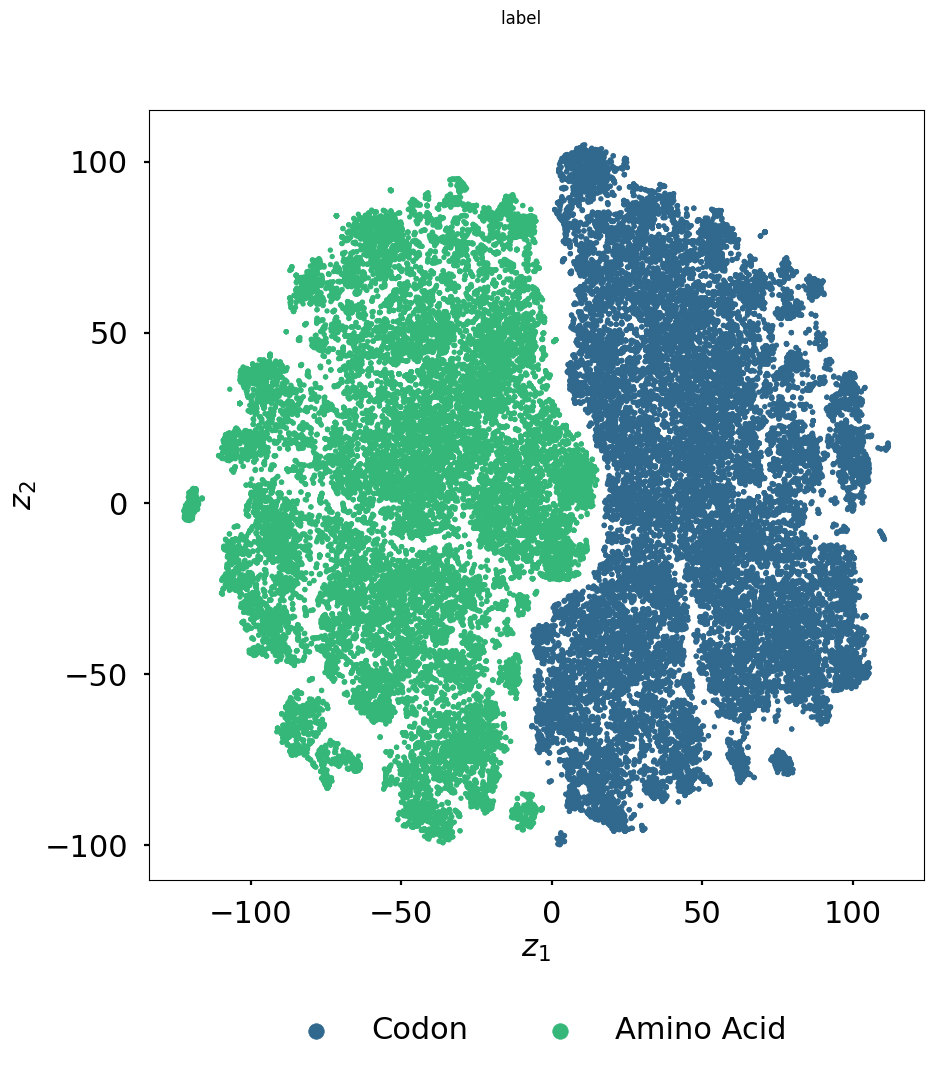

In [38]:
# Combined Codon + Amino Acid embeddings
tsne_embeddings = TSNE(n_components=2).fit_transform(combined_embeddings)
plot_df = pd.DataFrame({"x": tsne_embeddings[:, 0], "y": tsne_embeddings[:, 1], "label": codon_or_aa})
scatter_plot(plot_df, "label")
plt.show()

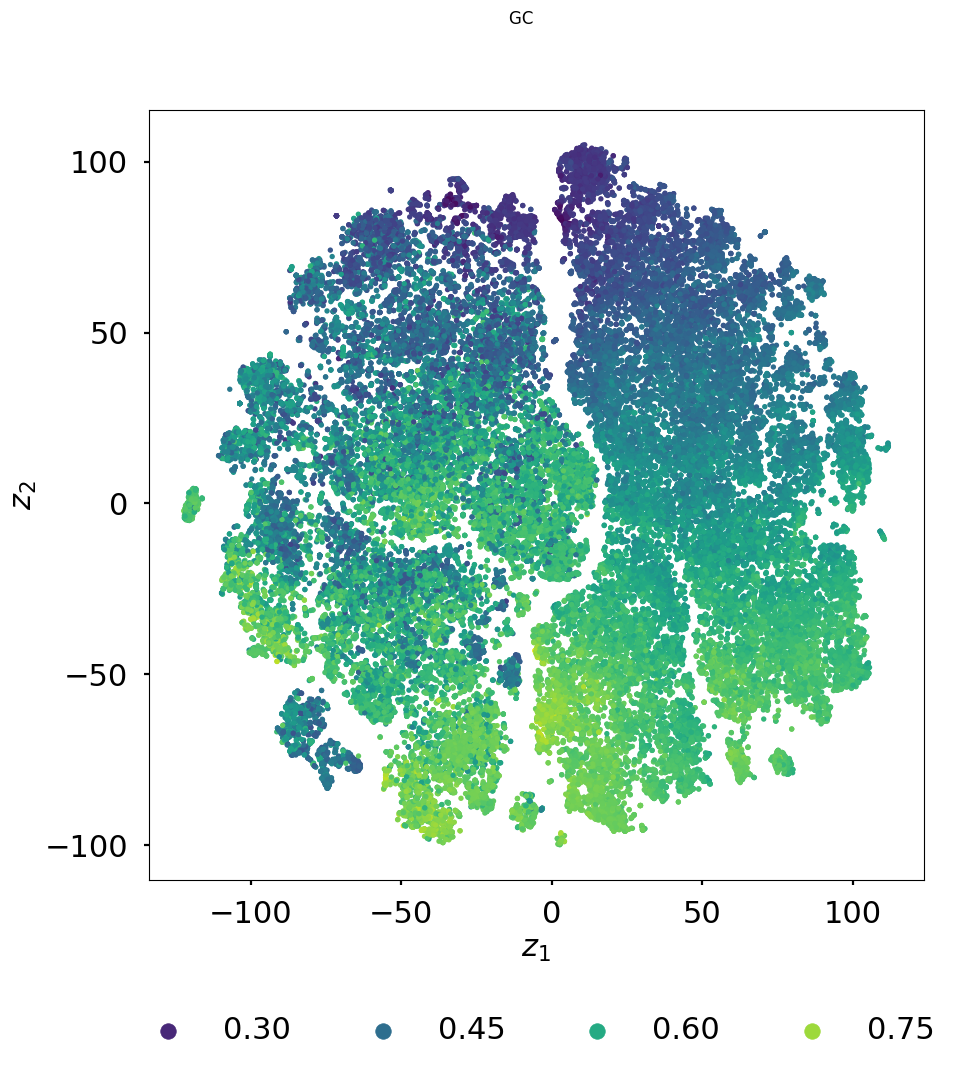

In [46]:
plot_df = pd.DataFrame({"x": tsne_embeddings[:, 0], "y": tsne_embeddings[:, 1], "GC": np.concatenate((gc_content, gc_content))})
scatter_plot(plot_df, "GC")
plt.show()

## Investigate whether the Codon and AA embeddings are within the top-k nearest neighbors
1. Embed codon sequences
2. Embed AA sequences
3. Find the top-k nearest neighbors for each sequence
4. For each codon sequence, count the number of times the AA sequence is in the top-k nearest neighbors

In [45]:
# Step 1 and 2 are done above
codon_embeddings = np.load("averaged_codon_embeddings.npy")
aminoacid_embeddings = np.load("averaged_aminoacid_embeddings.npy")